In [1]:
import os
import sys
# Here you need to have same Python version on your local machine adn on worker node i.e. EC2. here both should have python3.
os.environ["PYSPARK_PYTHON"] = "/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('CTR').getOrCreate()

In [3]:
!wget https://s3.amazonaws.com/sqoop.oozie.ml/credit_record.csv

--2020-10-04 18:33:04--  https://s3.amazonaws.com/sqoop.oozie.ml/credit_record.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.138.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.138.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15367102 (15M) [text/csv]
Saving to: ‘credit_record.csv.3’

100%[======================================>] 15,367,102  --.-K/s   in 0.1s    

2020-10-04 18:33:05 (106 MB/s) - ‘credit_record.csv.3’ saved [15367102/15367102]



In [4]:
!wget https://s3.amazonaws.com/sqoop.oozie.ml/application_record.csv

--2020-10-04 18:33:05--  https://s3.amazonaws.com/sqoop.oozie.ml/application_record.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.138.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.138.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54342959 (52M) [text/csv]
Saving to: ‘application_record.csv.1’

100%[======================================>] 54,342,959  76.1MB/s   in 0.7s   

2020-10-04 18:33:06 (76.1 MB/s) - ‘application_record.csv.1’ saved [54342959/54342959]



In [3]:
ar = spark.read.csv("application_record.csv", inferSchema=True, header=True)

In [4]:
ar.show()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment|    -12005|        -4542|         1

In [5]:
ar.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)



## 1. What is the proportion of females in the applicant customer base?

In [6]:
ar.columns

['ID',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS']

In [7]:
#for female
ar.filter(ar.CODE_GENDER == 'F').count() / ar.count()

0.6713836513839706

In [8]:
#for male
ar.filter(ar.CODE_GENDER == 'M').count() / ar.count()

0.3286163486160294

## 2. Is house ownership higher among male applicants or female applicants

In [9]:

#for female
ar.filter((ar.CODE_GENDER == 'F') & (ar.FLAG_OWN_REALTY == 'Y')).count() / ar.count()

0.4745973727474422

In [10]:
#for male
ar.filter((ar.CODE_GENDER == 'M') & (ar.FLAG_OWN_REALTY == 'Y')).count() / ar.count()

0.21875377659004416

In [11]:
# So female applicant has higher ownship

In [12]:
#function to 

In [13]:
from pyspark.sql.functions import when
#create a new column
#convert education ordinal feature as increasing numerically if education increases
ar = ar.withColumn('EDUCATION_LEVEL', when(ar.NAME_EDUCATION_TYPE == 'Lower secondary', 1)\
              .otherwise(when(ar.NAME_EDUCATION_TYPE == 'Secondary / secondary special', 2)\
                         .otherwise(when(ar.NAME_EDUCATION_TYPE == 'Incomplete higher', 3)\
                                    .otherwise(when(ar.NAME_EDUCATION_TYPE == 'Higher education', 4)\
                                              .otherwise(5)))))

In [14]:
ar = ar.drop('NAME_EDUCATION_TYPE')

In [15]:
ar.head()

Row(ID=5008804, CODE_GENDER='M', FLAG_OWN_CAR='Y', FLAG_OWN_REALTY='Y', CNT_CHILDREN=0, AMT_INCOME_TOTAL=427500.0, NAME_INCOME_TYPE='Working', NAME_FAMILY_STATUS='Civil marriage', NAME_HOUSING_TYPE='Rented apartment', DAYS_BIRTH=-12005, DAYS_EMPLOYED=-4542, FLAG_MOBIL=1, FLAG_WORK_PHONE=1, FLAG_PHONE=0, FLAG_EMAIL=0, OCCUPATION_TYPE=None, CNT_FAM_MEMBERS=2.0, EDUCATION_LEVEL=4)

In [16]:
ar.select('EDUCATION_LEVEL').distinct().show()

+---------------+
|EDUCATION_LEVEL|
+---------------+
|              1|
|              3|
|              5|
|              4|
|              2|
+---------------+



### 3. Is there any correlation between income levels and education level?

In [17]:
ar_pd = ar.toPandas()

In [18]:
# belows shows that the corelation coefficent is 0.23 and it positively related to AMT_INCOME_TOTAL
ar_pd[['EDUCATION_LEVEL','AMT_INCOME_TOTAL']].corr()

,EDUCATION_LEVEL,AMT_INCOME_TOTAL
EDUCATION_LEVEL,1.000000,0.221403
AMT_INCOME_TOTAL,0.221403,1.000000


## 4. What is the average and median salary of the applicant base?

In [19]:
# 50 percentile in the median
ar.select('AMT_INCOME_TOTAL').summary().show()

+-------+------------------+
|summary|  AMT_INCOME_TOTAL|
+-------+------------------+
|  count|            438557|
|   mean| 187524.2860095039|
| stddev|110086.85306622987|
|    min|           26100.0|
|    25%|          121500.0|
|    50%|          160650.0|
|    75%|          225000.0|
|    max|         6750000.0|
+-------+------------------+



In [20]:
#read credit record
cr = spark.read.csv("credit_record.csv", inferSchema=True, header=True)

In [21]:
cr.show()

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     X|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
|5001712|             0|     C|
|5001712|            -1|     C|
|5001712|            -2|     C|
|5001712|            -3|     C|
|5001712|            -4|     C|
|5001712|            -5|     C|
|5001712|            -6|     C|
|5001712|            -7|     C|
|5001712|            -8|     C|
|5001712|            -9|     0|
|5001712|           -10|     0|
|5001712|           -11|     0|
|5001712|           -12|     0|
|5001712|           -13|     0|
|5001712|           -14|     0|
|5001712|           -15|     0|
+-------+--------------+------+
only showing top 20 rows



In [22]:
from pyspark.sql.functions import col 
cr = cr.withColumn('DELENQUENT', when((cr['STATUS'] == '2') | (cr['STATUS'] == '3')| (cr['STATUS'] == '4')| (cr['STATUS'] == '5')  , 1).otherwise(0))

In [23]:
from pyspark.sql.functions import *
cr = cr.select('ID','DELENQUENT').groupby('ID').agg(max('DELENQUENT').alias('DELENQUENT'))

In [24]:
cr.count()

45985

In [25]:
cr.groupBy("DELENQUENT").count().show()

+----------+-----+
|DELENQUENT|count|
+----------+-----+
|         1|  667|
|         0|45318|
+----------+-----+



In [26]:
#rename the column name before joining
cr = cr.select(cr['ID'].alias('ID1'), 'DELENQUENT')

In [27]:
df = ar.join(cr, ar.ID == cr.ID1, how='inner').drop('ID1')

In [28]:
df.show()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---------------+----------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|EDUCATION_LEVEL|DELENQUENT|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---------------+----------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|      Civil marriage| Rented apartment|    -12005|        -4542|         1|  

In [29]:
df.count()

36457

## 5. Is the proportion of bad customers higher for people who own cars?

In [30]:
# who owns Cars
df.filter((df.FLAG_OWN_CAR == 'Y') & (df.DELENQUENT == 1)).count() / df.filter(df.DELENQUENT == 1).count()

0.36363636363636365

In [31]:
# who doesn't owns Cars
df.filter((df.FLAG_OWN_CAR == 'N') & (df.DELENQUENT == 1)).count() / df.filter(df.DELENQUENT == 1).count()

0.6363636363636364

## 6. Do people living on rent have a higher proportion of bad customers compared to the rest of the population?

In [32]:
# who lives on rent
df.filter((df.NAME_HOUSING_TYPE == 'Rented apartment') & (df.DELENQUENT == 1)).count() / df.filter(df.DELENQUENT == 1).count()

0.012987012987012988

In [33]:
# who doen't lives on rent
df.filter(~(df.NAME_HOUSING_TYPE == 'Rented apartment') & (df.DELENQUENT == 1)).count() / df.filter(df.DELENQUENT == 1).count()

0.987012987012987

## 7. Do single customers have a high proportion of bad customers compared to married customers

In [34]:
# who are married
df.filter(((df.NAME_FAMILY_STATUS == 'Married') | (df.NAME_FAMILY_STATUS == 'Civil marriage')) & (df.DELENQUENT == 1)).count() / df.filter(df.DELENQUENT == 1).count()

0.7126623376623377

In [35]:
# who are not married
df.filter(~((df.NAME_FAMILY_STATUS == 'Married') | (df.NAME_FAMILY_STATUS == 'Civil marriage')) & (df.DELENQUENT == 1)).count() / df.filter(df.DELENQUENT == 1).count()

0.28733766233766234

## Model build and EDA

In [36]:
#below are not need any more
ar = ''
cr = ''


In [37]:
#get the statics overview
df.summary().show()

+-------+-----------------+-----------+------------+---------------+-------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+----------+-------------------+-------------------+-------------------+--------------------+------------------+------------------+--------------------+
|summary|               ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|       CNT_CHILDREN|  AMT_INCOME_TOTAL|    NAME_INCOME_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|        DAYS_BIRTH|     DAYS_EMPLOYED|FLAG_MOBIL|    FLAG_WORK_PHONE|         FLAG_PHONE|         FLAG_EMAIL|     OCCUPATION_TYPE|   CNT_FAM_MEMBERS|   EDUCATION_LEVEL|          DELENQUENT|
+-------+-----------------+-----------+------------+---------------+-------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+----------+-------------------+-------------------+-------------------+----------------

In [38]:
#convert CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_CAR
df = df.withColumn('CODE_GENDER_NUM', when(df.CODE_GENDER == 'M', 1).otherwise(0))
df = df.withColumn('FLAG_OWN_CAR_NUM', when(df.FLAG_OWN_CAR == 'Y', 1).otherwise(0))
df = df.withColumn('FLAG_OWN_REALTY_NUM', when(df.FLAG_OWN_REALTY == 'Y', 1).otherwise(0))

In [39]:
#DAYS_EMPLOYED and DAYS_BIRTH are in negative convert them to postive and to years
df = df.withColumn('AGE_EMPLOYED', (df.DAYS_EMPLOYED * -1) / 365)

In [40]:
df = df.withColumn('AGE', (df.DAYS_BIRTH * -1) / 365)

In [41]:
#drop redundant columns
df = df.drop('CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','DAYS_EMPLOYED', 'DAYS_BIRTH')

In [42]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- EDUCATION_LEVEL: integer (nullable = false)
 |-- DELENQUENT: integer (nullable = true)
 |-- CODE_GENDER_NUM: integer (nullable = false)
 |-- FLAG_OWN_CAR_NUM: integer (nullable = false)
 |-- FLAG_OWN_REALTY_NUM: integer (nullable = false)
 |-- AGE_EMPLOYED: double (nullable = true)
 |-- AGE: double (nullable = true)



In [43]:
df.count()

36457

In [44]:
df.select('OCCUPATION_TYPE').summary().show()

+-------+--------------------+
|summary|     OCCUPATION_TYPE|
+-------+--------------------+
|  count|               25134|
|   mean|                null|
| stddev|                null|
|    min|         Accountants|
|    25%|                null|
|    50%|                null|
|    75%|                null|
|    max|Waiters/barmen staff|
+-------+--------------------+



In [45]:
# we can see that occupation type total and count is different which the missing value
36457 - 25134

11323

In [46]:
#impute them with 'Missing' text as this is only column with missing value
df = df.fillna('Missing')


In [47]:
df.select('OCCUPATION_TYPE').distinct().show()

+--------------------+
|     OCCUPATION_TYPE|
+--------------------+
|            Managers|
|            HR staff|
|      Medicine staff|
|         Accountants|
|            Laborers|
|      Cleaning staff|
|Private service s...|
|             Drivers|
|         Sales staff|
|       Realty agents|
|            IT staff|
|             Missing|
|      Security staff|
|         Secretaries|
|  Low-skill Laborers|
|          Core staff|
|       Cooking staff|
|High skill tech s...|
|Waiters/barmen staff|
+--------------------+



In [48]:
#we can see the Missing text above

In [49]:
df_pd = df.toPandas()

In [50]:
from xverse.transformer import MonotonicBinning
from xverse.transformer import WOE
clf = WOE()
clf.fit(df_pd.drop(columns=['ID','DELENQUENT']), df_pd['DELENQUENT'])

/home/ec2-user/.local/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


WOE(mono_custom_binning={'AGE': array([20.51780822, 37.10958904, 49.54794521, 68.90958904]),
                         'AGE_EMPLOYED': array([-1000.66575342,     2.08767123,     6.88219178,    43.04931507]),
                         'AMT_INCOME_TOTAL': array([  27000.,  135000.,  202500., 1575000.]),
                         'CNT_CHILDREN': array([ 0.,  1., 19.]),
                         'CNT_FAM_MEMBERS': array([ 1.,  2., 20.]),
                         'CODE_GENDER_NUM': array([0., 1.]),
                         'EDUCATION_LEVEL': array([...
                                  'Laborers': -0.059288675759952725,
                                  'Low-skill Laborers': 1.0250485342148945,
                                  'Managers': -0.08088390476995357,
                                  'Medicine staff': -0.721387807612114,
                                  'Missing': 0.014149371041716879,
                                  'Private service staff': -1.078062751550846,
                   

In [51]:
woe_df = clf.woe_df

In [52]:
woe_df

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
0,AGE,"(20.517, 37.11]",12156,216,11940,0.017769,0.982231,0.350649,0.333138,0.051230,0.004690
1,AGE,"(37.11, 49.548]",12149,186,11963,0.015310,0.984690,0.301948,0.333780,-0.100226,0.004690
2,AGE,"(49.548, 68.91]",12152,214,11938,0.017610,0.982390,0.347403,0.333082,0.042095,0.004690
3,AGE_EMPLOYED,"(-1000.667, 2.088]",12174,247,11927,0.020289,0.979711,0.400974,0.332775,0.186429,0.026508
4,AGE_EMPLOYED,"(2.088, 6.882]",12155,203,11952,0.016701,0.983299,0.329545,0.333473,-0.011847,0.026508
...,...,...,...,...,...,...,...,...,...,...,...
61,OCCUPATION_TYPE,Realty agents,79,0,79,0.000000,1.000000,0.000000,0.002204,0.000000,0.060582
62,OCCUPATION_TYPE,Sales staff,3485,45,3440,0.012912,0.987088,0.073052,0.095979,-0.272963,0.060582
63,OCCUPATION_TYPE,Secretaries,151,2,149,0.013245,0.986755,0.003247,0.004157,-0.247198,0.060582
64,OCCUPATION_TYPE,Security staff,592,13,579,0.021959,0.978041,0.021104,0.016155,0.267248,0.060582


In [53]:
woe_df.groupby('Variable_Name').max().reset_index()

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
0,AGE,"(49.548, 68.91]",12156,216,11963,0.017769,0.984690,0.350649,0.333780,0.051230,0.004690
1,AGE_EMPLOYED,"(6.882, 43.049]",12174,247,11962,0.020289,0.986313,0.400974,0.333752,0.186429,0.026508
2,AMT_INCOME_TOTAL,"(202500.0, 1575000.0]",14473,257,14216,0.017757,0.984582,0.417208,0.396641,0.050554,0.003572
3,CNT_CHILDREN,"(1.0, 19.0]",32693,551,32142,0.017269,0.983146,0.894481,0.896794,0.022170,0.000057
4,CNT_FAM_MEMBERS,"(2.0, 20.0]",26450,452,25998,0.017089,0.983611,0.733766,0.725370,0.011508,0.000357
5,CODE_GENDER_NUM,1,24430,379,24051,0.019706,0.984486,0.615260,0.671047,0.156654,0.013581
6,EDUCATION_LEVEL,5,24777,402,24375,0.026738,1.000000,0.652597,0.680087,0.469032,0.009209
7,FLAG_EMAIL,1,33186,564,32622,0.016995,0.984103,0.915584,0.910187,0.005913,0.000366
8,FLAG_MOBIL,1,36457,616,35841,0.016897,0.983103,1.000000,1.000000,0.000000,0.000000
9,FLAG_OWN_CAR_NUM,1,22614,392,22222,0.017334,0.983819,0.636364,0.620016,0.026025,0.001144


#### We can remove CNT_CHILDREN, CNT_FEM_MEMBERS, FLAG_EMAIL, FLAG_MOBIL, FLAG_OWN_CAR_NUM,  FLAG_PHONE,  FLAG_WORK_PHONE

In [54]:
df = df.drop('CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'FLAG_EMAIL', 'FLAG_MOBIL', 'FLAG_OWN_CAR_NUM',  'FLAG_PHONE',  'FLAG_WORK_PHONE')

In [55]:
df_pd = df.toPandas()
clf = WOE()
clf.fit(df_pd.drop(columns=['ID','DELENQUENT']), df_pd['DELENQUENT'])
woe_df = clf.woe_df

/home/ec2-user/.local/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [56]:
woe_df.groupby('Variable_Name').max().reset_index()

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
0,AGE,"(49.548, 68.91]",12156,216,11963,0.017769,0.984690,0.350649,0.333780,0.051230,0.004690
1,AGE_EMPLOYED,"(6.882, 43.049]",12174,247,11962,0.020289,0.986313,0.400974,0.333752,0.186429,0.026508
2,AMT_INCOME_TOTAL,"(202500.0, 1575000.0]",14473,257,14216,0.017757,0.984582,0.417208,0.396641,0.050554,0.003572
3,CODE_GENDER_NUM,1,24430,379,24051,0.019706,0.984486,0.615260,0.671047,0.156654,0.013581
4,EDUCATION_LEVEL,5,24777,402,24375,0.026738,1.000000,0.652597,0.680087,0.469032,0.009209
5,FLAG_OWN_REALTY_NUM,1,24506,365,24141,0.021002,0.985106,0.592532,0.673558,0.221710,0.028349
6,NAME_FAMILY_STATUS,Widow,25048,393,24655,0.029373,0.985259,0.637987,0.687899,0.565747,0.030119
7,NAME_HOUSING_TYPE,With parents,32548,540,32008,0.034351,0.986087,0.876623,0.893055,0.727436,0.015711
8,NAME_INCOME_TYPE,Working,18819,306,18513,0.021131,1.000000,0.496753,0.516531,0.227961,0.017556
9,OCCUPATION_TYPE,Waiters/barmen staff,11323,194,11129,0.050000,1.000000,0.314935,0.310510,1.119162,0.060582


In [57]:
woe_df[woe_df["Variable_Name"] == 'AGE']

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
0,AGE,"(20.517, 37.11]",12156,216,11940,0.017769,0.982231,0.350649,0.333138,0.051230,0.00469
1,AGE,"(37.11, 49.548]",12149,186,11963,0.015310,0.984690,0.301948,0.333780,-0.100226,0.00469
2,AGE,"(49.548, 68.91]",12152,214,11938,0.017610,0.982390,0.347403,0.333082,0.042095,0.00469


In [58]:
#replace woe value to corresponding field
df = df.withColumn('AGE_WOE', when((df.AGE >= 20.517) & (df.AGE <= 37.11), 0.051230)\
              .otherwise(when((df.AGE > 37.11) & (df.AGE <= 49.548), -0.100226)\
                         .otherwise(when((df.AGE > 49.548) & (df.AGE <= 68.91), 0.042095))))

In [59]:
woe_df[woe_df["Variable_Name"] == 'AGE_EMPLOYED']

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
3,AGE_EMPLOYED,"(-1000.667, 2.088]",12174,247,11927,0.020289,0.979711,0.400974,0.332775,0.186429,0.026508
4,AGE_EMPLOYED,"(2.088, 6.882]",12155,203,11952,0.016701,0.983299,0.329545,0.333473,-0.011847,0.026508
5,AGE_EMPLOYED,"(6.882, 43.049]",12128,166,11962,0.013687,0.986313,0.269481,0.333752,-0.213902,0.026508


In [60]:
#replace woe value to corresponding field
df = df.withColumn('AGE_EMPLOYED_WOE', when((df.AGE_EMPLOYED >= -1000.667) & (df.AGE_EMPLOYED <= 2.088), 0.186429)\
              .otherwise(when((df.AGE_EMPLOYED > 2.088) & (df.AGE_EMPLOYED <= 6.882), -0.011847)\
                         .otherwise(when((df.AGE_EMPLOYED > 6.882) & (df.AGE_EMPLOYED <= 43.049), -0.213902))))

In [61]:
woe_df[woe_df["Variable_Name"] == 'AMT_INCOME_TOTAL']

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
6,AMT_INCOME_TOTAL,"(26999.999, 135000.0]",14473,257,14216,0.017757,0.982243,0.417208,0.396641,0.050554,0.003572
7,AMT_INCOME_TOTAL,"(135000.0, 202500.0]",10702,165,10537,0.015418,0.984582,0.267857,0.293993,-0.093102,0.003572
8,AMT_INCOME_TOTAL,"(202500.0, 1575000.0]",11282,194,11088,0.017196,0.982804,0.314935,0.309366,0.017840,0.003572


In [62]:
#replace woe value to corresponding field
df = df.withColumn('AMT_INCOME_TOTAL_WOE', when((df.AMT_INCOME_TOTAL >= 26999.999) & (df.AMT_INCOME_TOTAL <= 135000.0), 0.050554)\
              .otherwise(when((df.AMT_INCOME_TOTAL > 135000.0) & (df.AMT_INCOME_TOTAL <= 202500.0), -0.093102)\
                         .otherwise(when((df.AMT_INCOME_TOTAL > 202500.0) & (df.AMT_INCOME_TOTAL <= 1575000.0), 0.017840))))

In [63]:
woe_df[woe_df["Variable_Name"] == 'CODE_GENDER_NUM']

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
9,CODE_GENDER_NUM,0,24430,379,24051,0.015514,0.984486,0.61526,0.671047,-0.086795,0.013581
10,CODE_GENDER_NUM,1,12027,237,11790,0.019706,0.980294,0.38474,0.328953,0.156654,0.013581


In [64]:
#Create dictionary and UDF
#Key of Dictinary will hold the Category (like 0 or 1 for binary) of a Feature/Column and value will WOE
def replaceCategoryToWOE(variable_name):
    dict_woe = {}
    for index, row in woe_df[woe_df['Variable_Name'] == variable_name].iterrows():
        k = row['Category']
        v = row['WOE']
        dict_woe[k] = v
    return dict_woe

In [65]:
#UDF that will return the value of the corresponding category of a variable
from pyspark.sql.types import IntegerType,DoubleType
from pyspark.sql.functions import udf
def getWoeValueOfaCatgory(in_dict):
    def f(x):
        return in_dict.get(x)
    return udf(f)

In [66]:
#Categorical variables are
#1. EDUCATION_LEVEL
#2. CODE_GENDER_NUM
#3. FLAG_OWN_REALTY_NUM
#4. NAME_FAMILY_STATUS
#5. NAME_HOUSING_TYPE
#6. NAME_INCOME_TYPE
#7. OCCUPATION_TYPE

In [67]:
woe_df[woe_df["Variable_Name"] == 'EDUCATION_LEVEL']

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
11,EDUCATION_LEVEL,1,374,10,364,0.026738,0.973262,0.016234,0.010156,0.469032,0.009209
12,EDUCATION_LEVEL,2,24777,402,24375,0.016225,0.983775,0.652597,0.680087,-0.041260,0.009209
13,EDUCATION_LEVEL,3,1410,33,1377,0.023404,0.976596,0.053571,0.038420,0.332446,0.009209
14,EDUCATION_LEVEL,4,9864,171,9693,0.017336,0.982664,0.277597,0.270444,0.026105,0.009209
15,EDUCATION_LEVEL,5,32,0,32,0.000000,1.000000,0.000000,0.000893,0.000000,0.009209


In [68]:
#We have to replace the cateogry with the corresponding WOE value in the original spark dataframe
dict_woe = replaceCategoryToWOE('EDUCATION_LEVEL')
df = df.withColumn('EDUCATION_LEVEL_WOE', getWoeValueOfaCatgory(dict_woe)(df.EDUCATION_LEVEL))

In [69]:
df.select('EDUCATION_LEVEL','EDUCATION_LEVEL_WOE').groupby('EDUCATION_LEVEL').agg(max('EDUCATION_LEVEL_WOE')).show()

+---------------+------------------------+
|EDUCATION_LEVEL|max(EDUCATION_LEVEL_WOE)|
+---------------+------------------------+
|              1|      0.4690320303091186|
|              3|      0.3324458676896392|
|              5|                     0.0|
|              4|     0.02610510696186555|
|              2|    -0.04126040229521308|
+---------------+------------------------+



#### from above we can see that cateogorical variable is replacing with actual woe value correctly, now do similar for rest of the item

In [70]:

dict_woe = replaceCategoryToWOE('CODE_GENDER_NUM')
df = df.withColumn('CODE_GENDER_NUM_WOE', getWoeValueOfaCatgory(dict_woe)(df.CODE_GENDER_NUM))

In [71]:
dict_woe = replaceCategoryToWOE('FLAG_OWN_REALTY_NUM')
df = df.withColumn('FLAG_OWN_REALTY_NUM_WOE', getWoeValueOfaCatgory(dict_woe)(df.FLAG_OWN_REALTY_NUM))

In [72]:

dict_woe = replaceCategoryToWOE('NAME_FAMILY_STATUS')
df = df.withColumn('NAME_FAMILY_STATUS_WOE', getWoeValueOfaCatgory(dict_woe)(df.NAME_FAMILY_STATUS))

In [73]:
dict_woe = replaceCategoryToWOE('NAME_HOUSING_TYPE')
df = df.withColumn('NAME_HOUSING_TYPE_WOE', getWoeValueOfaCatgory(dict_woe)(df.NAME_HOUSING_TYPE))

In [74]:
dict_woe = replaceCategoryToWOE('NAME_INCOME_TYPE')
df = df.withColumn('NAME_INCOME_TYPE_WOE', getWoeValueOfaCatgory(dict_woe)(df.NAME_INCOME_TYPE))

In [75]:
woe_df[woe_df["Variable_Name"] == 'OCCUPATION_TYPE']

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
34,OCCUPATION_TYPE,Accountants,1241,23,1218,0.018533,0.981467,0.037338,0.033983,0.094130,0.060582
35,OCCUPATION_TYPE,Cleaning staff,551,5,546,0.009074,0.990926,0.008117,0.015234,-0.629580,0.060582
36,OCCUPATION_TYPE,Cooking staff,655,9,646,0.013740,0.986260,0.014610,0.018024,-0.209974,0.060582
37,OCCUPATION_TYPE,Core staff,3591,74,3517,0.020607,0.979393,0.120130,0.098128,0.202302,0.060582
38,OCCUPATION_TYPE,Drivers,2138,49,2089,0.022919,0.977081,0.079545,0.058285,0.310980,0.060582
39,OCCUPATION_TYPE,HR staff,85,1,84,0.011765,0.988235,0.001623,0.002344,-0.367216,0.060582
40,OCCUPATION_TYPE,High skill tech staff,1383,30,1353,0.021692,0.978308,0.048701,0.037750,0.254719,0.060582
41,OCCUPATION_TYPE,IT staff,60,3,57,0.050000,0.950000,0.004870,0.001590,1.119162,0.060582
42,OCCUPATION_TYPE,Laborers,6211,99,6112,0.015939,0.984061,0.160714,0.170531,-0.059289,0.060582
43,OCCUPATION_TYPE,Low-skill Laborers,175,8,167,0.045714,0.954286,0.012987,0.004659,1.025049,0.060582


In [76]:
dict_woe = replaceCategoryToWOE('OCCUPATION_TYPE')

In [77]:
dict_woe

{'Accountants': 0.09412957261112086,
 'Cleaning staff': -0.6295802583589911,
 'Cooking staff': -0.20997412149456882,
 'Core staff': 0.202302265682001,
 'Drivers': 0.3109803415058745,
 'HR staff': -0.36721599389149984,
 'High skill tech staff': 0.2547185584431811,
 'IT staff': 1.119161825785373,
 'Laborers': -0.059288675759952725,
 'Low-skill Laborers': 1.0250485342148945,
 'Managers': -0.08088390476995357,
 'Medicine staff': -0.721387807612114,
 'Missing': 0.014149371041716879,
 'Private service staff': -1.078062751550846,
 'Realty agents': 0.0,
 'Sales staff': -0.27296345564531077,
 'Secretaries': -0.24719832043369996,
 'Security staff': 0.2672476848403552,
 'Waiters/barmen staff': -0.390746491301694}

In [78]:
df = df.withColumn('OCCUPATION_TYPE_WOE', getWoeValueOfaCatgory(dict_woe)(df.OCCUPATION_TYPE))

In [79]:
df

DataFrame[ID: int, AMT_INCOME_TOTAL: double, NAME_INCOME_TYPE: string, NAME_FAMILY_STATUS: string, NAME_HOUSING_TYPE: string, OCCUPATION_TYPE: string, EDUCATION_LEVEL: int, DELENQUENT: int, CODE_GENDER_NUM: int, FLAG_OWN_REALTY_NUM: int, AGE_EMPLOYED: double, AGE: double, AGE_WOE: double, AGE_EMPLOYED_WOE: double, AMT_INCOME_TOTAL_WOE: double, EDUCATION_LEVEL_WOE: string, CODE_GENDER_NUM_WOE: string, FLAG_OWN_REALTY_NUM_WOE: string, NAME_FAMILY_STATUS_WOE: string, NAME_HOUSING_TYPE_WOE: string, NAME_INCOME_TYPE_WOE: string, OCCUPATION_TYPE_WOE: string]

In [80]:
#now drop the corlumn without woe
df = df.drop('AMT_INCOME_TOTAL','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE',
'EDUCATION_LEVEL','CODE_GENDER_NUM', 'FLAG_OWN_REALTY_NUM','AGE_EMPLOYED','AGE')

In [81]:
df

DataFrame[ID: int, DELENQUENT: int, AGE_WOE: double, AGE_EMPLOYED_WOE: double, AMT_INCOME_TOTAL_WOE: double, EDUCATION_LEVEL_WOE: string, CODE_GENDER_NUM_WOE: string, FLAG_OWN_REALTY_NUM_WOE: string, NAME_FAMILY_STATUS_WOE: string, NAME_HOUSING_TYPE_WOE: string, NAME_INCOME_TYPE_WOE: string, OCCUPATION_TYPE_WOE: string]

In [82]:
df.show()

+-------+----------+---------+----------------+--------------------+--------------------+--------------------+-----------------------+----------------------+---------------------+--------------------+--------------------+
|     ID|DELENQUENT|  AGE_WOE|AGE_EMPLOYED_WOE|AMT_INCOME_TOTAL_WOE| EDUCATION_LEVEL_WOE| CODE_GENDER_NUM_WOE|FLAG_OWN_REALTY_NUM_WOE|NAME_FAMILY_STATUS_WOE|NAME_HOUSING_TYPE_WOE|NAME_INCOME_TYPE_WOE| OCCUPATION_TYPE_WOE|
+-------+----------+---------+----------------+--------------------+--------------------+--------------------+-----------------------+----------------------+---------------------+--------------------+--------------------+
|5008804|         0|  0.05123|       -0.213902|             0.01784| 0.02610510696186555| 0.15665395255552828|   -0.12816876027993723|  -0.07987892748074678| -0.19731695709610228| -0.0390425600849821|0.014149371041716879|
|5008805|         0|  0.05123|       -0.213902|             0.01784| 0.02610510696186555| 0.15665395255552828|  

In [83]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- DELENQUENT: integer (nullable = true)
 |-- AGE_WOE: double (nullable = true)
 |-- AGE_EMPLOYED_WOE: double (nullable = true)
 |-- AMT_INCOME_TOTAL_WOE: double (nullable = true)
 |-- EDUCATION_LEVEL_WOE: string (nullable = true)
 |-- CODE_GENDER_NUM_WOE: string (nullable = true)
 |-- FLAG_OWN_REALTY_NUM_WOE: string (nullable = true)
 |-- NAME_FAMILY_STATUS_WOE: string (nullable = true)
 |-- NAME_HOUSING_TYPE_WOE: string (nullable = true)
 |-- NAME_INCOME_TYPE_WOE: string (nullable = true)
 |-- OCCUPATION_TYPE_WOE: string (nullable = true)



In [84]:
#Correct all the string type to double

In [85]:
df = df.withColumn("CODE_GENDER_NUM_WOE", df['CODE_GENDER_NUM_WOE'].cast(DoubleType()))
df = df.withColumn("EDUCATION_LEVEL_WOE", df['EDUCATION_LEVEL_WOE'].cast(DoubleType()))
df = df.withColumn("FLAG_OWN_REALTY_NUM_WOE", df['FLAG_OWN_REALTY_NUM_WOE'].cast(DoubleType()))
df = df.withColumn("NAME_FAMILY_STATUS_WOE", df['NAME_FAMILY_STATUS_WOE'].cast(DoubleType()))
df = df.withColumn("NAME_HOUSING_TYPE_WOE", df['NAME_HOUSING_TYPE_WOE'].cast(DoubleType()))
df = df.withColumn("NAME_INCOME_TYPE_WOE", df['NAME_INCOME_TYPE_WOE'].cast(DoubleType()))
df = df.withColumn("OCCUPATION_TYPE_WOE", df['OCCUPATION_TYPE_WOE'].cast(DoubleType()))


In [86]:
#Now again check for the schema
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- DELENQUENT: integer (nullable = true)
 |-- AGE_WOE: double (nullable = true)
 |-- AGE_EMPLOYED_WOE: double (nullable = true)
 |-- AMT_INCOME_TOTAL_WOE: double (nullable = true)
 |-- EDUCATION_LEVEL_WOE: double (nullable = true)
 |-- CODE_GENDER_NUM_WOE: double (nullable = true)
 |-- FLAG_OWN_REALTY_NUM_WOE: double (nullable = true)
 |-- NAME_FAMILY_STATUS_WOE: double (nullable = true)
 |-- NAME_HOUSING_TYPE_WOE: double (nullable = true)
 |-- NAME_INCOME_TYPE_WOE: double (nullable = true)
 |-- OCCUPATION_TYPE_WOE: double (nullable = true)



In [87]:
df = df.dropna()

### Now above data is fit for logistics regression model building

In [88]:
df_pd = df.toPandas()

In [89]:
df_pd

,ID,DELENQUENT,AGE_WOE,AGE_EMPLOYED_WOE,AMT_INCOME_TOTAL_WOE,EDUCATION_LEVEL_WOE,CODE_GENDER_NUM_WOE,FLAG_OWN_REALTY_NUM_WOE,NAME_FAMILY_STATUS_WOE,NAME_HOUSING_TYPE_WOE,NAME_INCOME_TYPE_WOE,OCCUPATION_TYPE_WOE
0,5008804,0,0.051230,-0.213902,0.017840,0.026105,0.156654,-0.128169,-0.079879,-0.197317,-0.039043,0.014149
1,5008805,0,0.051230,-0.213902,0.017840,0.026105,0.156654,-0.128169,-0.079879,-0.197317,-0.039043,0.014149
2,5008806,0,0.042095,-0.011847,0.050554,-0.041260,0.156654,-0.128169,-0.075325,-0.018571,-0.039043,0.267248
3,5008808,0,0.042095,-0.213902,0.017840,-0.041260,-0.086795,-0.128169,0.217464,-0.018571,-0.003212,-0.272963
4,5008809,0,0.042095,-0.213902,0.017840,-0.041260,-0.086795,-0.128169,0.217464,-0.018571,-0.003212,-0.272963
...,...,...,...,...,...,...,...,...,...,...,...,...
36451,5149828,1,-0.100226,-0.011847,0.017840,-0.041260,0.156654,-0.128169,-0.075325,-0.018571,-0.039043,-0.080884
36452,5149834,1,0.051230,-0.011847,-0.093102,0.026105,-0.086795,-0.128169,-0.075325,-0.018571,-0.003212,-0.721388
36453,5149838,1,0.051230,-0.011847,-0.093102,0.026105,-0.086795,-0.128169,-0.075325,-0.018571,0.227961,-0.721388
36454,5150049,1,-0.100226,0.186429,0.017840,-0.041260,-0.086795,-0.128169,-0.075325,-0.018571,-0.039043,-0.272963


In [89]:
!pip3 install seaborn

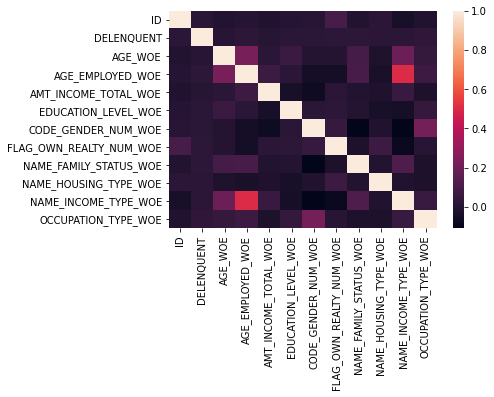

In [90]:
#check the correlation
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df_pd.corr())
plt.show()

### Above we can see every feature is not controlled just AGE_EMPLOYED_WOE is correlated with NAME_INCOME_TYPE_WOE

In [91]:
df_copy = df

In [92]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler

In [94]:
df = df_copy
trainCols = df.drop('ID','DELENQUENT').columns

In [95]:
trainCols

['AGE_WOE',
 'AGE_EMPLOYED_WOE',
 'AMT_INCOME_TOTAL_WOE',
 'EDUCATION_LEVEL_WOE',
 'CODE_GENDER_NUM_WOE',
 'FLAG_OWN_REALTY_NUM_WOE',
 'NAME_FAMILY_STATUS_WOE',
 'NAME_HOUSING_TYPE_WOE',
 'NAME_INCOME_TYPE_WOE',
 'OCCUPATION_TYPE_WOE']

In [96]:

assembler = VectorAssembler(inputCols=trainCols, outputCol='features')
df = assembler.transform(df)

In [97]:
df.select('features').head()

Row(features=DenseVector([0.0512, -0.2139, 0.0178, 0.0261, 0.1567, -0.1282, -0.0799, -0.1973, -0.039, 0.0141]))

In [98]:
df_train, df_test = df.randomSplit([0.7,0.3])

### Check the propotion of delenquent in both test and train

In [101]:
df_train.select('DELENQUENT').groupby('DELENQUENT').sum().show()

+----------+---------------+
|DELENQUENT|sum(DELENQUENT)|
+----------+---------------+
|         1|            445|
|         0|              0|
+----------+---------------+



In [102]:
df_test.select('DELENQUENT').groupby('DELENQUENT').sum().show()

+----------+---------------+
|DELENQUENT|sum(DELENQUENT)|
+----------+---------------+
|         1|            171|
|         0|              0|
+----------+---------------+



### Proportion seems ok, Otherwise we need to do the custom sampling as data is highly imbalanced

In [106]:
# train model in the training dataset

# import the logistic model
from pyspark.ml.classification import LogisticRegression

# create the logistic model, configure it and call fit it to the data. 
lr = LogisticRegression(featuresCol='features', labelCol='DELENQUENT')
model = lr.fit(df_train)

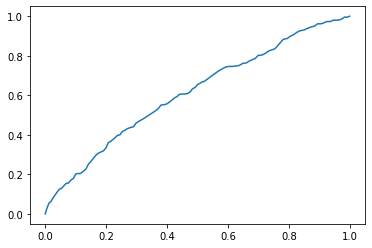

In [107]:
plt.plot(model.summary.roc.select('FPR').collect(), model.summary.roc.select('TPR').collect())
plt.show()

In [108]:
#evaluate themodel with test
result_test = model.evaluate(df_test)

result_test.recallByLabel

[1.0, 0.0]

In [109]:
result_test.predictions.show()

+-------+----------+---------+----------------+--------------------+--------------------+--------------------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     ID|DELENQUENT|  AGE_WOE|AGE_EMPLOYED_WOE|AMT_INCOME_TOTAL_WOE| EDUCATION_LEVEL_WOE| CODE_GENDER_NUM_WOE|FLAG_OWN_REALTY_NUM_WOE|NAME_FAMILY_STATUS_WOE|NAME_HOUSING_TYPE_WOE|NAME_INCOME_TYPE_WOE| OCCUPATION_TYPE_WOE|            features|       rawPrediction|         probability|prediction|
+-------+----------+---------+----------------+--------------------+--------------------+--------------------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|5008808|         0| 0.042095|       -0.213902|             0.01784|-0.04126040229521308|-0.08679484467682119|  

In [110]:
#see if the data is there in predicted 
result_test.predictions.select('DELENQUENT','probability').filter(col('DELENQUENT')==1).orderBy(col('probability')).count()

171

In [111]:
thresh = result_test.predictions.select('DELENQUENT','probability')

In [112]:
thresh.show()

+----------+--------------------+
|DELENQUENT|         probability|
+----------+--------------------+
|         0|[0.98862400022834...|
|         0|[0.98234859732855...|
|         0|[0.98517301570377...|
|         0|[0.98517301570377...|
|         0|[0.98517301570377...|
|         0|[0.98555427376069...|
|         0|[0.98484041055023...|
|         0|[0.98484041055023...|
|         0|[0.98895767847997...|
|         0|[0.98895767847997...|
|         0|[0.98895767847997...|
|         0|[0.98895767847997...|
|         0|[0.98895767847997...|
|         0|[0.98707968070069...|
|         0|[0.98287423234157...|
|         0|[0.98580074525516...|
|         0|[0.98580074525516...|
|         0|[0.98551872092462...|
|         0|[0.98551872092462...|
|         0|[0.98804419726069...|
+----------+--------------------+
only showing top 20 rows



In [116]:
 
result_test.predictions.coalesce(1).toPandas()

,ID,DELENQUENT,AGE_WOE,AGE_EMPLOYED_WOE,AMT_INCOME_TOTAL_WOE,EDUCATION_LEVEL_WOE,CODE_GENDER_NUM_WOE,FLAG_OWN_REALTY_NUM_WOE,NAME_FAMILY_STATUS_WOE,NAME_HOUSING_TYPE_WOE,NAME_INCOME_TYPE_WOE,OCCUPATION_TYPE_WOE,features,rawPrediction,probability,prediction
0,5008808,0,0.042095,-0.213902,0.017840,-0.041260,-0.086795,-0.128169,0.217464,-0.018571,-0.003212,-0.272963,"[0.042095, -0.213902, 0.01784, -0.041260402295...","[4.4648082245754965, -4.4648082245754965]","[0.9886240002283415, 0.011375999771658403]",0.0
1,5008815,0,-0.100226,-0.011847,0.017840,0.026105,0.156654,-0.128169,-0.075325,-0.018571,-0.039043,0.094130,"[-0.100226, -0.011847, 0.01784, 0.026105106961...","[4.019130980765891, -4.019130980765891]","[0.9823485973285504, 0.017651402671449566]",0.0
2,5008820,0,-0.100226,-0.011847,0.050554,-0.041260,0.156654,-0.128169,-0.075325,-0.018571,-0.003212,-0.059289,"[-0.100226, -0.011847, 0.050554, -0.0412604022...","[4.196368492306596, -4.196368492306596]","[0.985173015703778, 0.014826984296221918]",0.0
3,5008822,0,-0.100226,-0.011847,0.050554,-0.041260,0.156654,-0.128169,-0.075325,-0.018571,-0.003212,-0.059289,"[-0.100226, -0.011847, 0.050554, -0.0412604022...","[4.196368492306596, -4.196368492306596]","[0.985173015703778, 0.014826984296221918]",0.0
4,5008824,0,-0.100226,-0.011847,0.050554,-0.041260,0.156654,-0.128169,-0.075325,-0.018571,-0.003212,-0.059289,"[-0.100226, -0.011847, 0.050554, -0.0412604022...","[4.196368492306596, -4.196368492306596]","[0.985173015703778, 0.014826984296221918]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11019,5145690,1,0.042095,0.186429,0.017840,0.026105,-0.086795,-0.128169,-0.075325,-0.018571,0.227961,0.014149,"[0.042095, 0.186429, 0.01784, 0.02610510696186...","[3.939916312877458, -3.939916312877458]","[0.9809212365630073, 0.01907876343699253]",0.0
11020,5145846,1,-0.100226,-0.011847,0.017840,0.026105,-0.086795,-0.128169,-0.075325,-0.018571,-0.314364,-0.080884,"[-0.100226, -0.011847, 0.01784, 0.026105106961...","[4.413797243707891, -4.413797243707891]","[0.9880357665374205, 0.01196423346257958]",0.0
11021,5146078,1,0.051230,-0.011847,0.050554,-0.041260,-0.086795,-0.128169,0.217464,-0.018571,-0.039043,-0.272963,"[0.05123, -0.011847, 0.050554, -0.041260402295...","[4.252771015707972, -4.252771015707972]","[0.985974743728953, 0.014025256271046987]",0.0
11022,5148934,1,-0.100226,-0.011847,0.050554,-0.041260,0.156654,0.221710,-0.075325,0.727436,-0.039043,0.267248,"[-0.100226, -0.011847, 0.050554, -0.0412604022...","[2.9326841694763077, -2.9326841694763077]","[0.9494386838289063, 0.050561316171093836]",0.0


In [117]:
#save to csv
 
result_test.predictions.coalesce(1).toPandas().to_csv('Predicated.csv')

In [118]:
from pyspark.sql.functions import udf, when
from pyspark.sql.types import FloatType

element_extrac=udf(lambda v:float(v[1]),FloatType())

In [119]:
result_list = []       # to store the values of precision and recall



threshold_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [120]:
for i in threshold_list:
    test_pred = thresh.withColumn('label_p',when(element_extrac(thresh["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("DELENQUENT==1 AND label_p==1").count()
    FP = test_pred.filter("DELENQUENT==0 AND label_p==1").count()
    FN = test_pred.filter("DELENQUENT==1 AND label_p==0").count()
    TN = test_pred.filter("DELENQUENT==0 AND label_p==0").count()  
    if TP == 0:
        recall = 0
        presession = 0
    else:
        recall = (TP/(TP+FN))
        presession = ((TP/(TP+FP)))
    list1 = []
    list1.append(i)
    list1.append(presession)
    list1.append(recall)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

In [121]:
# Create a panadas datafarme for the list of the output. 

# create a schema for the dataframes 
from pyspark.sql.types import *

schema = StructType([StructField('threshold', DoubleType(), True),
                      StructField('precision', IntegerType(), True),
                      StructField('recall', IntegerType(), True),
                      StructField('TP', IntegerType(), True),
                      StructField('TN', IntegerType(), True),
                      StructField('FP', IntegerType(), True),
                      StructField('FN', IntegerType(), True)])


# create a rdd from the list
rdd = spark.sparkContext.parallelize(result_list)



In [122]:
rdd.collect()

[[0.1, 0, 0, 0, 10850, 3, 171],
 [0.2, 0, 0, 0, 10853, 0, 171],
 [0.3, 0, 0, 0, 10853, 0, 171],
 [0.4, 0, 0, 0, 10853, 0, 171],
 [0.5, 0, 0, 0, 10853, 0, 171],
 [0.6, 0, 0, 0, 10853, 0, 171],
 [0.7, 0, 0, 0, 10853, 0, 171],
 [0.8, 0, 0, 0, 10853, 0, 171],
 [0.9, 0, 0, 0, 10853, 0, 171]]

In [123]:
schema

StructType(List(StructField(threshold,DoubleType,true),StructField(precision,IntegerType,true),StructField(recall,IntegerType,true),StructField(TP,IntegerType,true),StructField(TN,IntegerType,true),StructField(FP,IntegerType,true),StructField(FN,IntegerType,true)))

In [124]:

# create a spark dataframe form rdd
thresh_df = spark.createDataFrame(rdd,schema)



In [125]:
thresh_df.show()

+---------+---------+------+---+-----+---+---+
|threshold|precision|recall| TP|   TN| FP| FN|
+---------+---------+------+---+-----+---+---+
|      0.1|        0|     0|  0|10850|  3|171|
|      0.2|        0|     0|  0|10853|  0|171|
|      0.3|        0|     0|  0|10853|  0|171|
|      0.4|        0|     0|  0|10853|  0|171|
|      0.5|        0|     0|  0|10853|  0|171|
|      0.6|        0|     0|  0|10853|  0|171|
|      0.7|        0|     0|  0|10853|  0|171|
|      0.8|        0|     0|  0|10853|  0|171|
|      0.9|        0|     0|  0|10853|  0|171|
+---------+---------+------+---+-----+---+---+



In [126]:
# create pandas dataframe form the spark dataframe 
pandas_df = thresh_df.toPandas()

In [127]:
thresh_df.show()

+---------+---------+------+---+-----+---+---+
|threshold|precision|recall| TP|   TN| FP| FN|
+---------+---------+------+---+-----+---+---+
|      0.1|        0|     0|  0|10850|  3|171|
|      0.2|        0|     0|  0|10853|  0|171|
|      0.3|        0|     0|  0|10853|  0|171|
|      0.4|        0|     0|  0|10853|  0|171|
|      0.5|        0|     0|  0|10853|  0|171|
|      0.6|        0|     0|  0|10853|  0|171|
|      0.7|        0|     0|  0|10853|  0|171|
|      0.8|        0|     0|  0|10853|  0|171|
|      0.9|        0|     0|  0|10853|  0|171|
+---------+---------+------+---+-----+---+---+



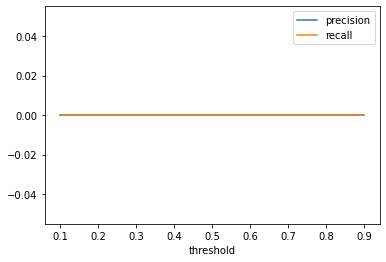

In [128]:
# import matplot lib 
import matplotlib.pyplot as plt

# create the plot
pandas_df.plot.line(x='threshold', y=['precision','recall'])

# display the plot
plt.show()

## seems need to set the threshold to correctly identify the bad custom